### K562 overexpression example

This notebook prepares a dataset from a tech-dev paper with a gazillion Perturb-seq experiments applied to mostly K562 ([Replogle et al 2020](https://www.nature.com/articles/s41587-020-0470-y)). We'll focus on just the CRISPRa multiplexing experiment, which does overexpression. 

Here we tidy the dataset and carry out a simple exploration in scanpy.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

import anndata
import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/gary/cahan_rotation/perturbation_data")

### How many TF's are perturbed?

In [2]:
dataset_name = "replogle"
human_tfs = pd.read_csv("setup/tfList.csv")
EpiList   = pd.read_csv("setup/epiList.csv", index_col=0).iloc[:, [0,14]]
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
replogle_perturbations = pd.read_csv(f"not_ready/{dataset_name}/perturbed_genes.csv")
replogle_perturbations.drop_duplicates(inplace = True)
replogle_perturbations["is_tf"] = replogle_perturbations["gene"].isin(human_tfs["HGNC symbol"]) # | replogle_perturbations["gene"].isin(EpiList["HGNC_symbol"]) 
display(replogle_perturbations.groupby("experiment").count()) #total
display(replogle_perturbations.groupby("experiment").sum()) #tf only
replogle_perturbations.query("experiment=='CRISPRa multiplex'")["gene"].unique() #which TF's

gene  is_tf
experiment                    
CRISPRa multiplex    63     63
CRISPRi multiplex   104    104
IPSC                 19     19
Interaction          41     42
UPR validation       30     30

is_tf
experiment              
CRISPRa multiplex     33
CRISPRi multiplex      9
IPSC                   5
Interaction            2
UPR validation         0

array(['CDKN1A', 'CDKN1B', 'CEBPB', 'CERKL', 'COL2A1', 'EOMES', 'ETS2',
       'FOXC1', 'HHEX', 'HIC2', 'HOXD13', 'IGDCC3', 'IRF1', 'KLF1',
       'LHX4', 'MAP2K3', 'MAP2K6', 'MAPK1', 'MEIS2', 'NEUROD1', 'NPM1',
       'PRTG', 'PTPN1', 'SET', 'SPI1', 'TIPARP', 'TLE3', 'TTC6', 'ZNF296',
       'AIRE', 'ASCL1', 'ATF4', 'ATF5', 'BACH2', 'CCDC51', 'COX5A',
       'CREB1', 'DDIT3', 'DDIT4', 'EIF2S1', 'FOXP3', 'GATA3', 'HIF1A',
       'HSF1', 'HSPA9', 'HSPD1', 'MTOR', 'NEUROG2', 'NRF1', 'PISD',
       'PPARGC1A', 'RANBP1', 'RORA', 'RPL30', 'RPS18', 'SREBF1', 'TBX21',
       'TFAP4', 'TIMM50', 'TMA7', 'UPF1', 'ZNF236', 'ZNF574'],
      dtype=object)

### Load expression data & set up cell metadata

In [3]:
if not os.path.exists(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip"):
    expression_quantified = sc.read_10x_mtx(f"not_ready/{dataset_name}/GSM4367986_exp8/")
    expression_quantified.write_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip", compression="gzip")
else:
    expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip")

In [4]:
sc.pp.calculate_qc_metrics(expression_quantified, inplace = True)
cell_metadata = pd.read_csv(f"not_ready/{dataset_name}/GSM4367986_exp8/cell_identities.csv.gz")
cell_metadata.index = cell_metadata["cell_barcode"]
cell_metadata["target_symbol"] = ingestion.convert_ens_to_symbol(
    cell_metadata["target"], 
    gtf = "setup/gencode.v35.annotation.gtf.gz", 
    strip_version = True)
cell_metadata["target_is_tf"] = cell_metadata["target_symbol"].isin(human_tfs["HGNC symbol"]).astype("int")
expression_quantified.obs = pd.merge(expression_quantified.obs,
                                     cell_metadata, 
                                     how = "left", 
                                     left_index = True, 
                                     right_index = True)

expression_quantified.obs["has_guide_annotations"] = pd.notnull(expression_quantified.obs["coverage"]).astype("int")
expression_quantified.obs["good_coverage"] = expression_quantified.obs["good_coverage"].astype("str")
expression_quantified.raw = expression_quantified.copy()

In [5]:
expression_quantified = expression_quantified[~expression_quantified.obs.target_symbol.isna(), :]

### How many cells do we have for each target?

target_symbol  n_cells  is_tf
0           CEBPB      212   True
1            LHX4      238   True
2           PTPN1      284  False
3          CDKN1B      303  False
4           TBX21      315   True
..            ...      ...    ...
59           TTC6     1513  False
60          RPL30     1712  False
61           MTOR     1735  False
62         MAP2K3     1861  False
63  Non-Targeting     5126  False

[64 rows x 3 columns]

Text(0.5, 1.0, 'CRISPRa in K562')

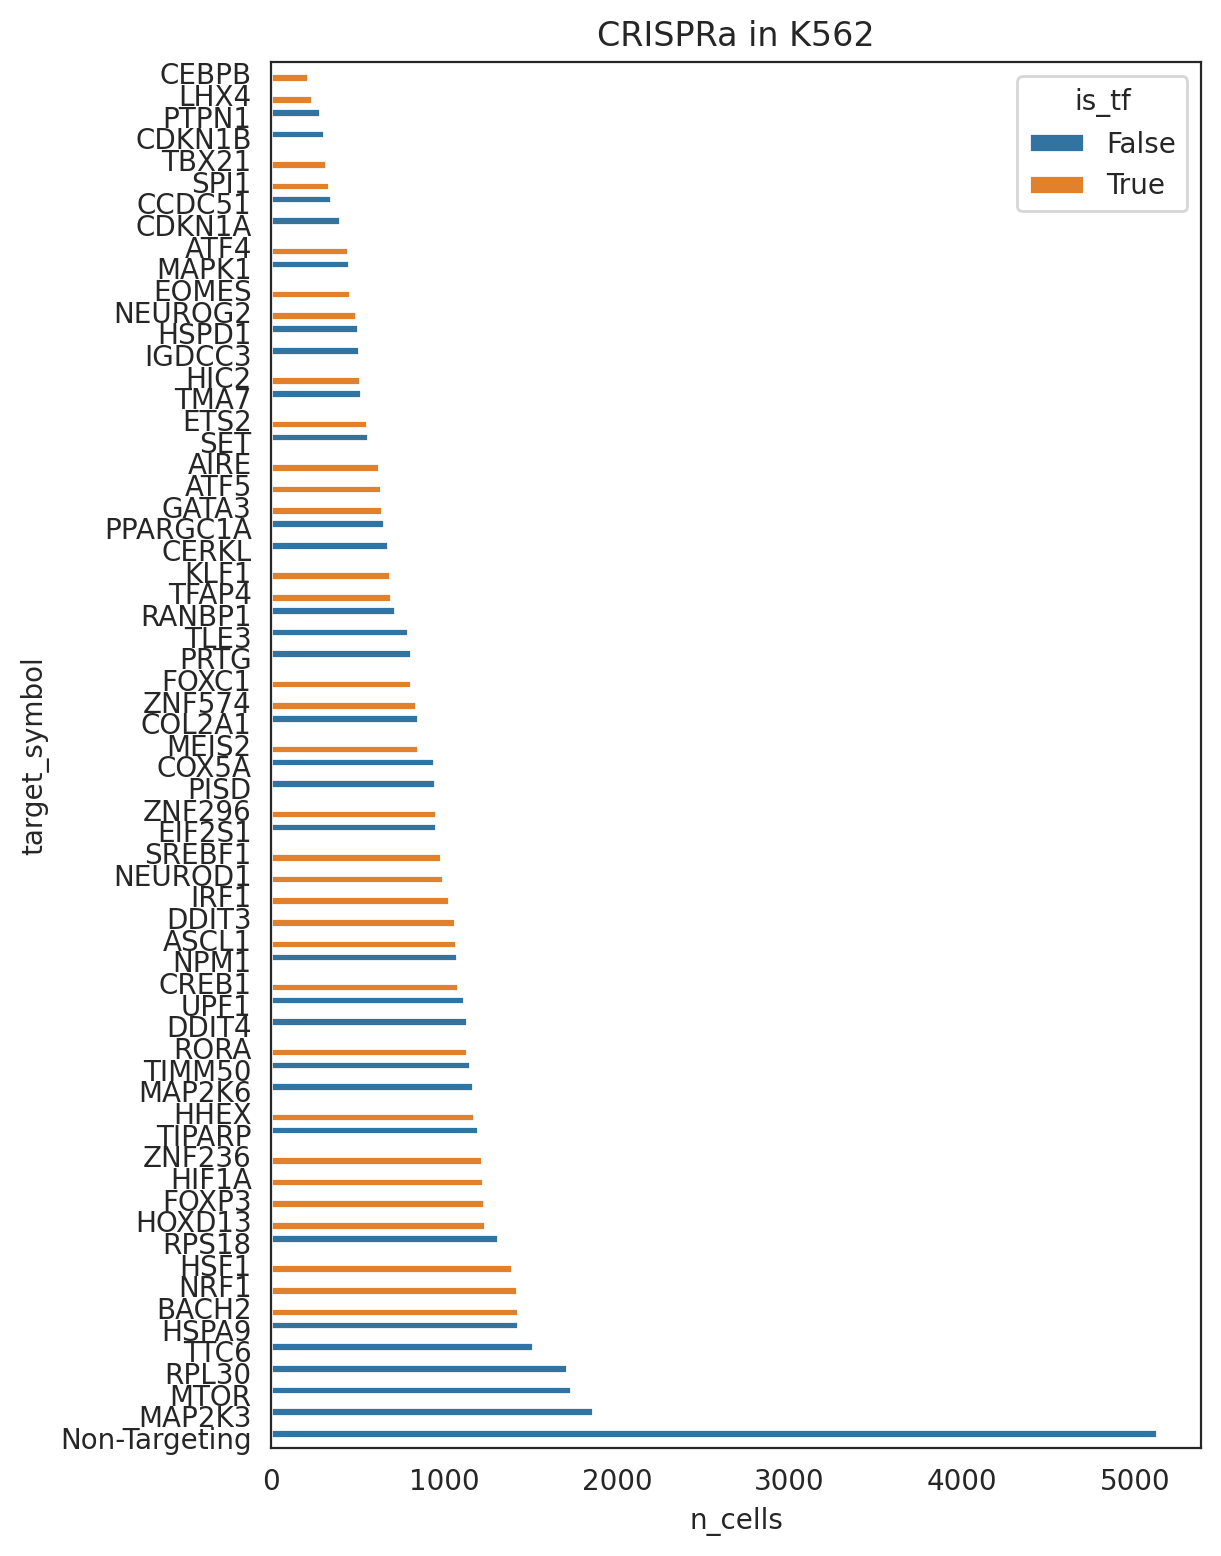

In [6]:
n_cells_per_target = expression_quantified.obs.groupby("target_symbol")[["cell_barcode"]].count().sort_values("cell_barcode")
n_cells_per_target.columns = ["n_cells"]
n_cells_per_target["is_tf"] = n_cells_per_target.index.isin(human_tfs["HGNC symbol"])
n_cells_per_target.reset_index(inplace = True)
display(n_cells_per_target)
plt.rcParams['figure.figsize'] = [6, 9]
sns.barplot(data = n_cells_per_target, x = "n_cells", y = "target_symbol", hue = "is_tf").set_title("CRISPRa in K562")

### Convert ensembl gene id's to gene symbol

In [7]:
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf = "setup/gencode.v35.annotation.gtf.gz", 
)
display(expression_quantified.var.head())
display(expression_quantified.var_names[0:5])

gene_ids    feature_types  n_cells_by_counts  \
RP11-34P13.3  ENSG00000243485  Gene Expression                 14   
FAM138A       ENSG00000237613  Gene Expression                  0   
OR4F5         ENSG00000186092  Gene Expression                  0   
RP11-34P13.7  ENSG00000238009  Gene Expression                343   
RP11-34P13.8  ENSG00000239945  Gene Expression                 55   

              mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
RP11-34P13.3     0.000127           0.000127              99.987326   
FAM138A          0.000000           0.000000             100.000000   
OR4F5            0.000000           0.000000             100.000000   
RP11-34P13.7     0.003105           0.003100              99.689486   
RP11-34P13.8     0.000498           0.000498              99.950209   

              total_counts  log1p_total_counts  
RP11-34P13.3          14.0            2.708050  
FAM138A                0.0            0.000000  
OR4F5                  0.0            0.000000  
RP11-34P13.7         343.0            5.840641  
RP11-34P13.8          55.0            4.025352

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8'], dtype='object')

### Fill `perturbation` & `Is_control`

In [8]:
controls = ["Non-Targeting"]
expression_quantified.obs["perturbation"]     = expression_quantified.obs['target_symbol']
expression_quantified.obs["is_control"]       = expression_quantified.obs['target_symbol'].isin(controls)
expression_quantified.obs["is_control_int"]   = expression_quantified.obs['target_symbol'].isin(controls).astype(int)

In [9]:
expression_quantified

AnnData object with n_obs × n_vars = 60725 × 33694
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cell_barcode', 'guide_identity', 'num_guides', 'gene', 'best_gamma', 'correction', 'distance', 'gamma_A', 'gamma_B', 'gene_type', 'protospacer_A', 'protospacer_B', 'rank_A', 'rank_B', 'sgID_A', 'sgID_B', 'type', 'target', 'umi_A', 'umi_B', 'read_count', 'UMI_count', 'coverage', 'good_coverage', 'number_of_cells', 'gemgroup', 'target_symbol', 'target_is_tf', 'has_guide_annotations', 'perturbation', 'is_control', 'is_control_int'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### QC filters

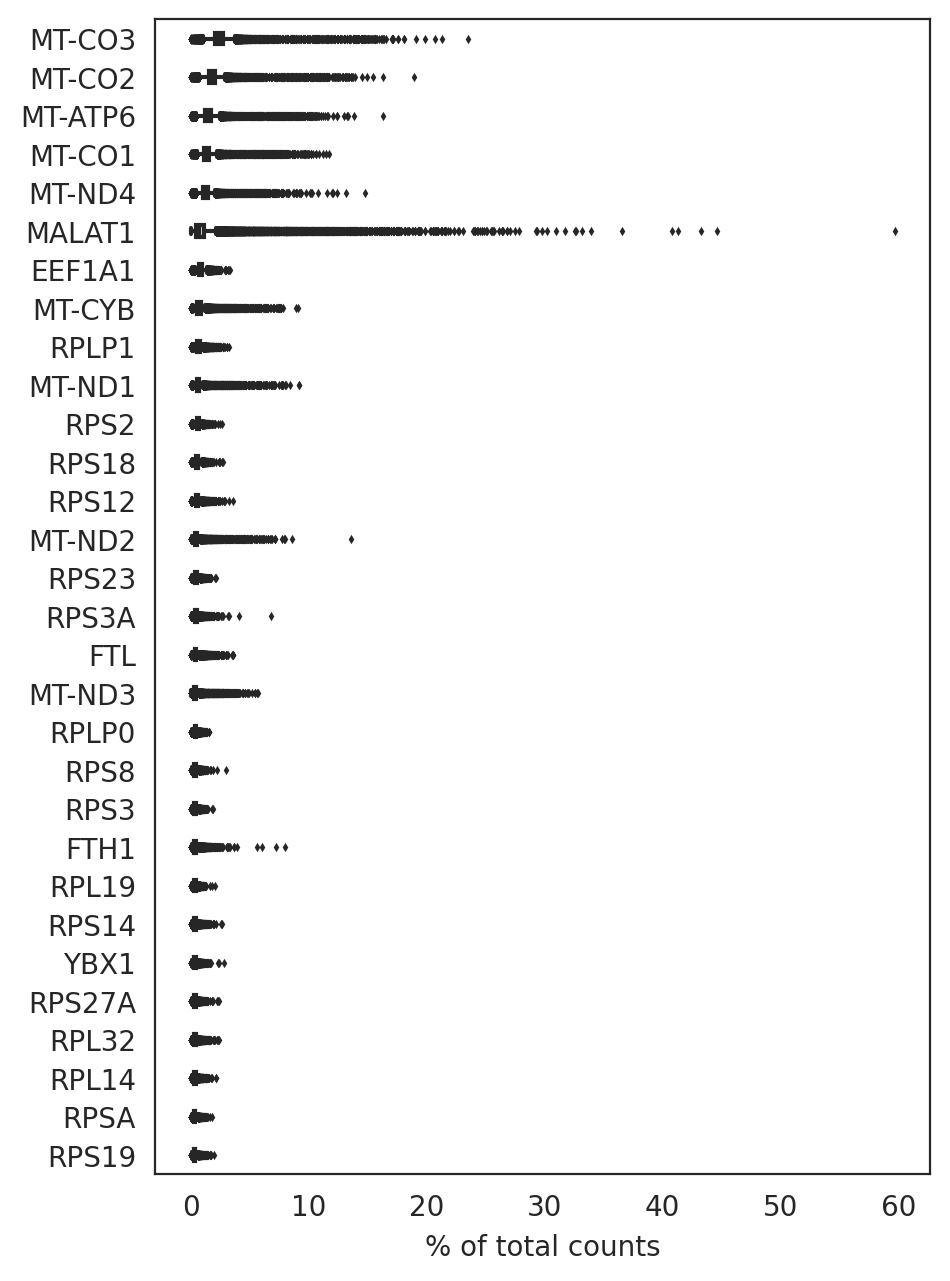

In [10]:
sc.pl.highest_expr_genes(expression_quantified, n_top=30, palette="Blues", width=.3)

In [11]:
expression_quantified.var['mt']   = expression_quantified.var_names.str.startswith(("MT-"))
expression_quantified.var['ribo'] = expression_quantified.var_names.str.startswith(("RPS","RPL"))
expression_quantified.var['mt'].sum(), expression_quantified.var['ribo'].sum(), 

(13, 103)

In [12]:
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

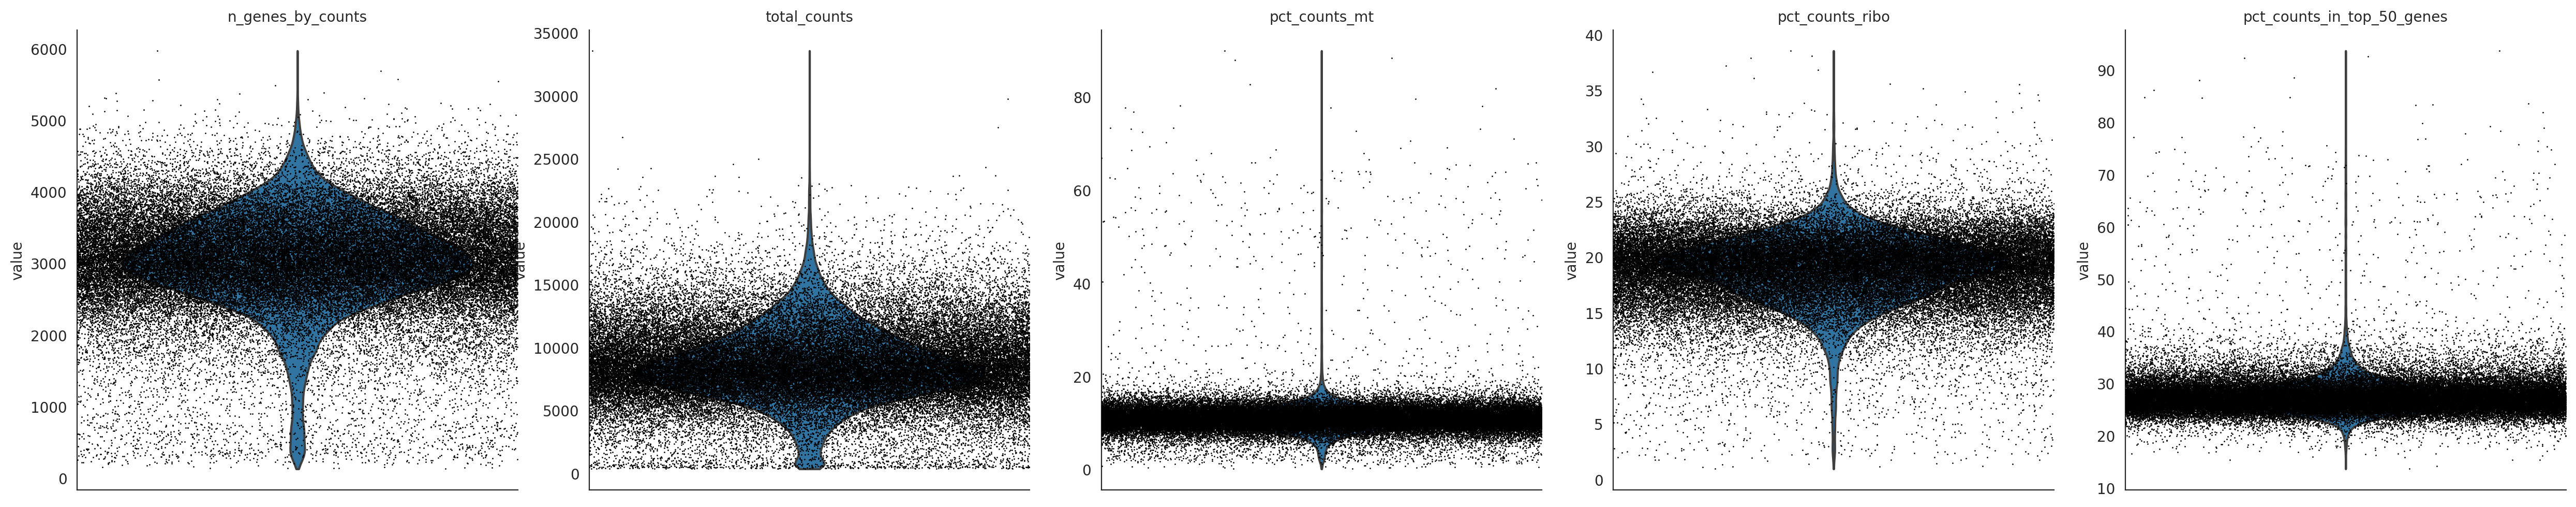

In [13]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.5, multi_panel=True)

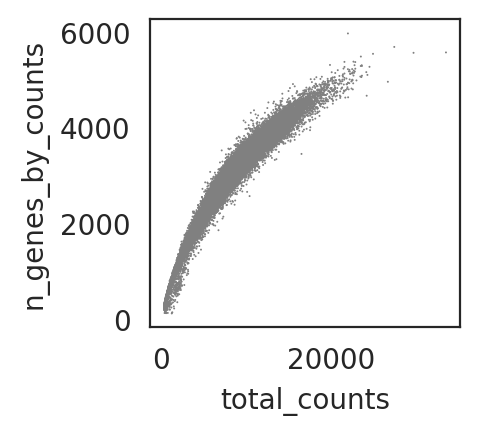

In [14]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [15]:
print("Number of cells: ", expression_quantified.n_obs)

# figure out the total counts == 95 percentile
thresh = np.percentile(expression_quantified.obs['total_counts'], 99)
print("95th percentile: ", thresh)

Number of cells:  60725
95th percentile:  17000.280000000006


In [16]:
expression_quantified = expression_quantified[expression_quantified.obs['total_counts'] < thresh, :]
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  60117


In [17]:
expression_quantified = expression_quantified[expression_quantified.obs["total_counts"] >= 2000, :]
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58809


In [18]:
expression_quantified = expression_quantified[expression_quantified.obs["pct_counts_in_top_50_genes"] <= 40, :]
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58589


In [19]:
# filter for % mt
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_mt'] < 20, :]
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58484


In [20]:
# filter for % ribo > 50%
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_ribo'] < 30, :]
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58415


In [21]:
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

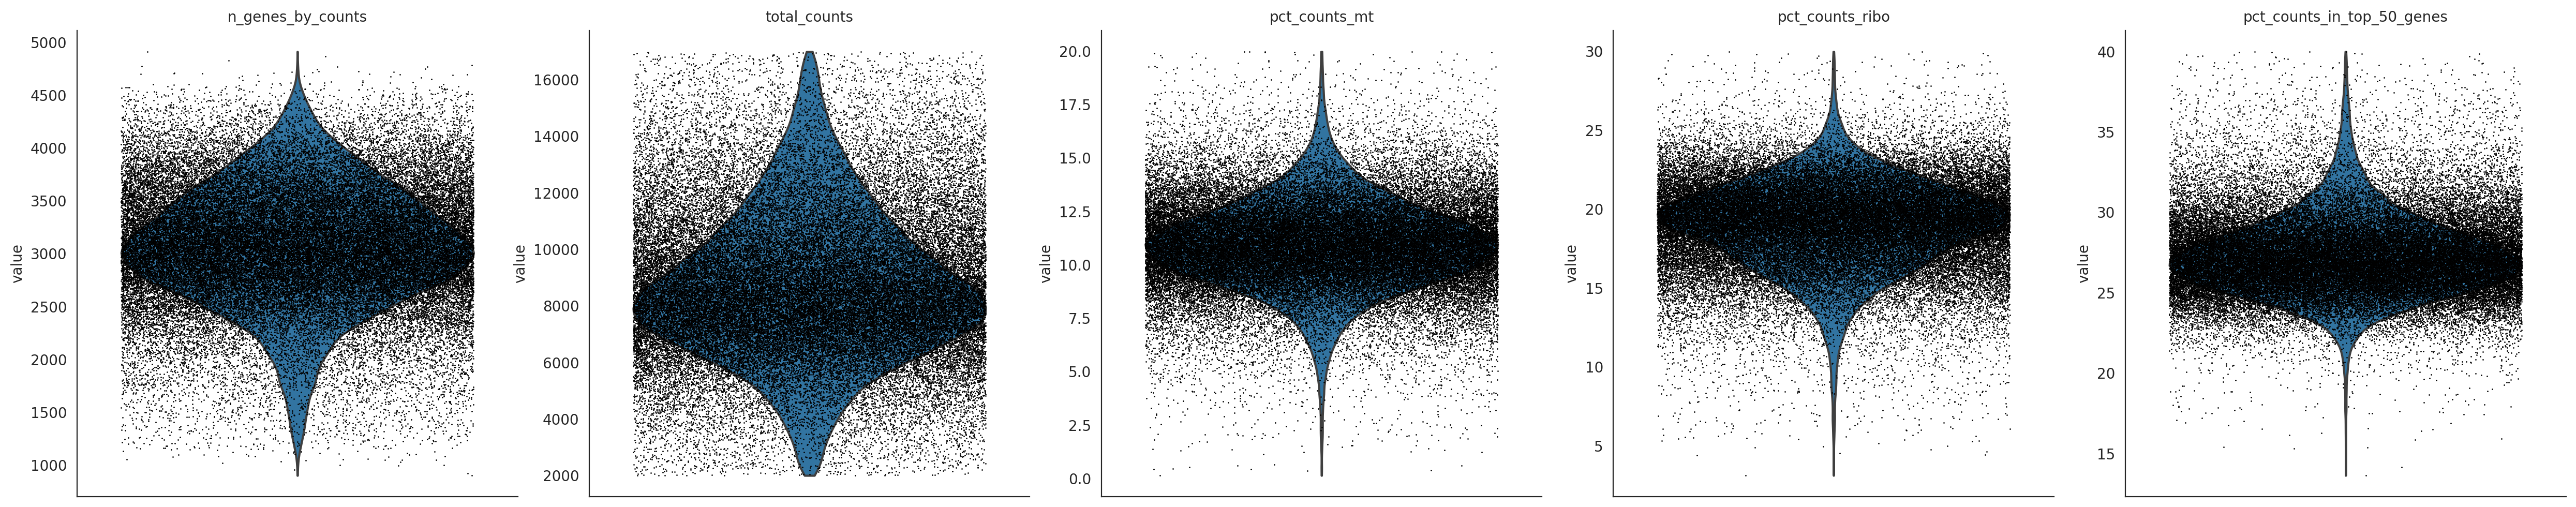

In [22]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

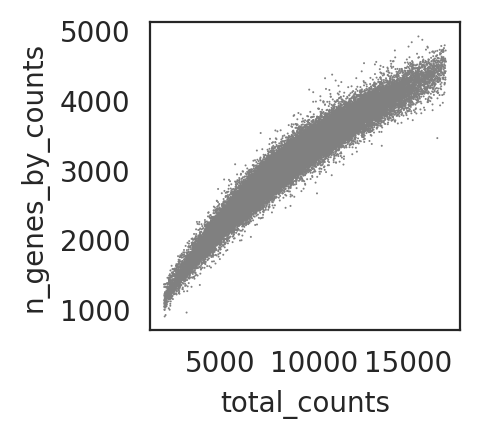

In [23]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [24]:
print("Number of genes: ", expression_quantified.n_vars)
gThresh = 10

sc.pp.filter_genes(expression_quantified, min_cells=gThresh)
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  33694
Number of genes:  18811


In [25]:
mito_genes = expression_quantified.var_names.str.startswith('MT-')
ribo_genes = expression_quantified.var_names.str.startswith(("RPL","RPS"))
malat_gene = expression_quantified.var_names.str.startswith("MALAT1")

In [26]:
remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)
keep = np.invert(remove)
expression_quantified = expression_quantified[:,keep].copy()
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  18700


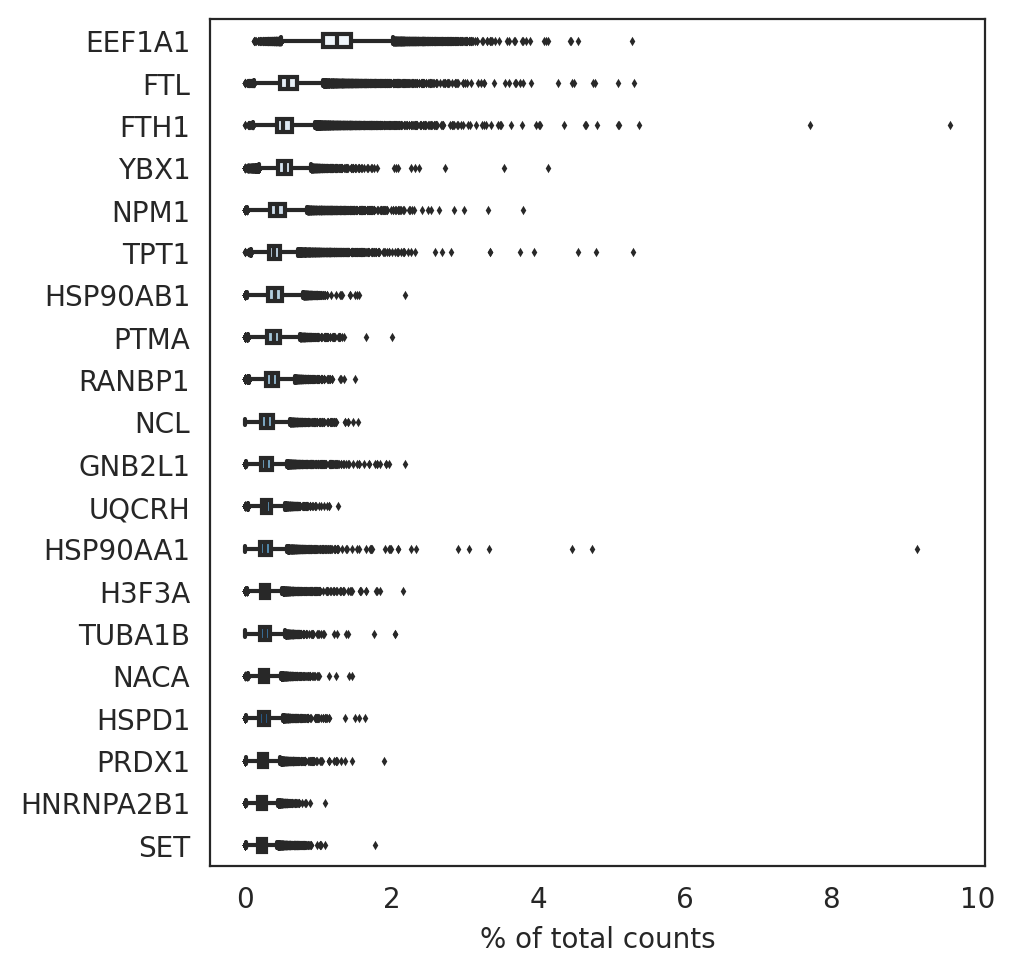

In [27]:
sc.pl.highest_expr_genes(expression_quantified, n_top=20, palette="Blues", width=.3)

In [28]:
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

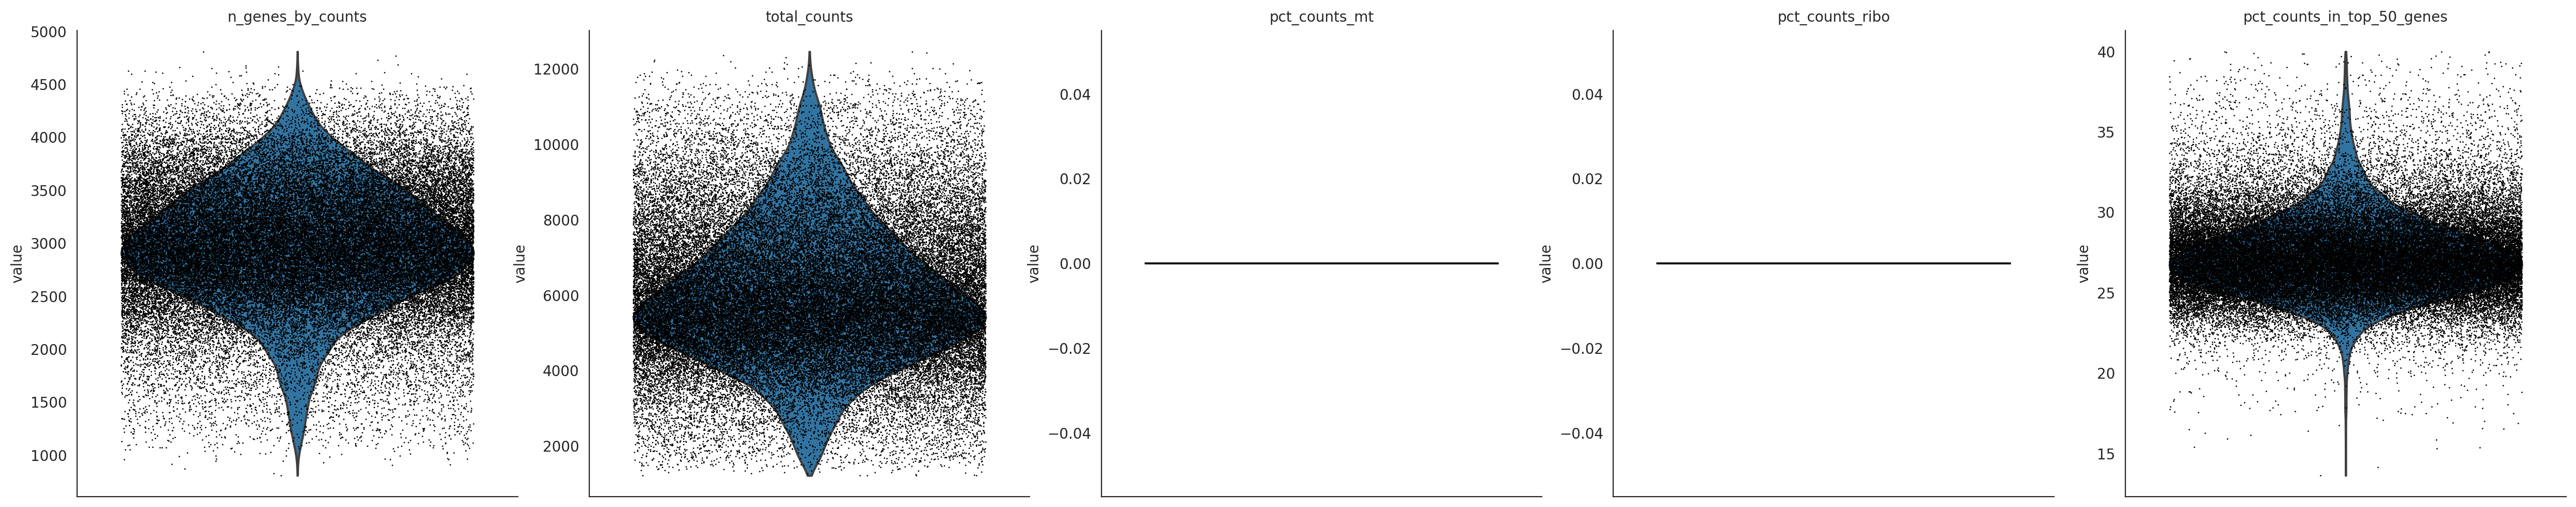

In [29]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

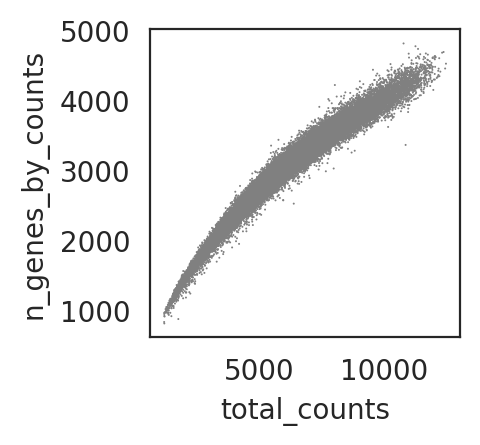

In [30]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [31]:
expression_quantified.raw = expression_quantified

### Aggregate For Pseudo-Bulk

In [32]:
def aggregate(adata: anndata.AnnData):
    ad1 = adata.copy()
    
    uniqueGroup = np.array([f"{i}*{j}" for i,j in zip(ad1.obs.target_symbol, ad1.obs.type)])
    rowIndex    = np.array([uniqueGroup == i for i in set(sorted(uniqueGroup))])
    """ essentially add 0.1 to all gene in a group with length sum(r). """
    newX        = np.squeeze([ad1.X[r,:].mean(axis=0) + 0.1 / sum(r) for r in rowIndex], axis=1)  
    newPerturb  = np.array([i.split("*")[0] for i in set(sorted(uniqueGroup))])
    newGuideRNA = np.array([i.split("*")[1] for i in set(sorted(uniqueGroup))])
    newControl  = np.array([True if 'Non-Targeting' in i else False for i in set(sorted(uniqueGroup))], dtype=bool)
    newObsMeta  = pd.DataFrame()
    newObsMeta['is_control']   = newControl
    newObsMeta['perturbation'] = newPerturb
    newObsMeta['guideRNA']     = newGuideRNA
    newAdata    = sc.AnnData(newX, 
                             var=ad1.var.copy(),
                             obs=newObsMeta)
    return newAdata
    
pseudobulk = aggregate(expression_quantified)

In [33]:
set(pseudobulk.obs.perturbation)

{'AIRE',
 'ASCL1',
 'ATF4',
 'ATF5',
 'BACH2',
 'CCDC51',
 'CDKN1A',
 'CDKN1B',
 'CEBPB',
 'CERKL',
 'COL2A1',
 'COX5A',
 'CREB1',
 'DDIT3',
 'DDIT4',
 'EIF2S1',
 'EOMES',
 'ETS2',
 'FOXC1',
 'FOXP3',
 'GATA3',
 'HHEX',
 'HIC2',
 'HIF1A',
 'HOXD13',
 'HSF1',
 'HSPA9',
 'HSPD1',
 'IGDCC3',
 'IRF1',
 'KLF1',
 'LHX4',
 'MAP2K3',
 'MAP2K6',
 'MAPK1',
 'MEIS2',
 'MTOR',
 'NEUROD1',
 'NEUROG2',
 'NPM1',
 'NRF1',
 'Non-Targeting',
 'PISD',
 'PPARGC1A',
 'PRTG',
 'PTPN1',
 'RANBP1',
 'RORA',
 'RPL30',
 'RPS18',
 'SET',
 'SPI1',
 'SREBF1',
 'TBX21',
 'TFAP4',
 'TIMM50',
 'TIPARP',
 'TLE3',
 'TMA7',
 'TTC6',
 'UPF1',
 'ZNF236',
 'ZNF296',
 'ZNF574'}

In [34]:
pseudobulk[pseudobulk.obs.perturbation == 'CCDC51'].obs

is_control perturbation   guideRNA
63        False       CCDC51        1_2
72        False       CCDC51  control_2
227       False       CCDC51  1_control

PearsonRResult(statistic=0.7158744457997284, pvalue=0.0)

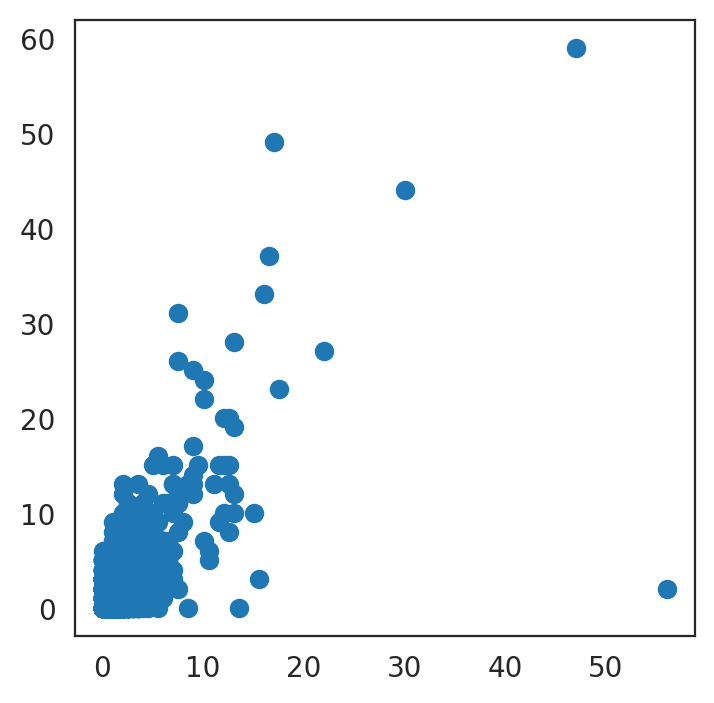

In [35]:
plt.figure(figsize=(4,4))
plt.scatter(pseudobulk[pseudobulk.obs.perturbation == 'CCDC51'].X[0,:], pseudobulk[pseudobulk.obs.perturbation == 'CCDC51'].X[2,:])
pearsonr(pseudobulk[pseudobulk.obs.perturbation == 'CCDC51'].X[0,:], pseudobulk[pseudobulk.obs.perturbation == 'CCDC51'].X[2,:])

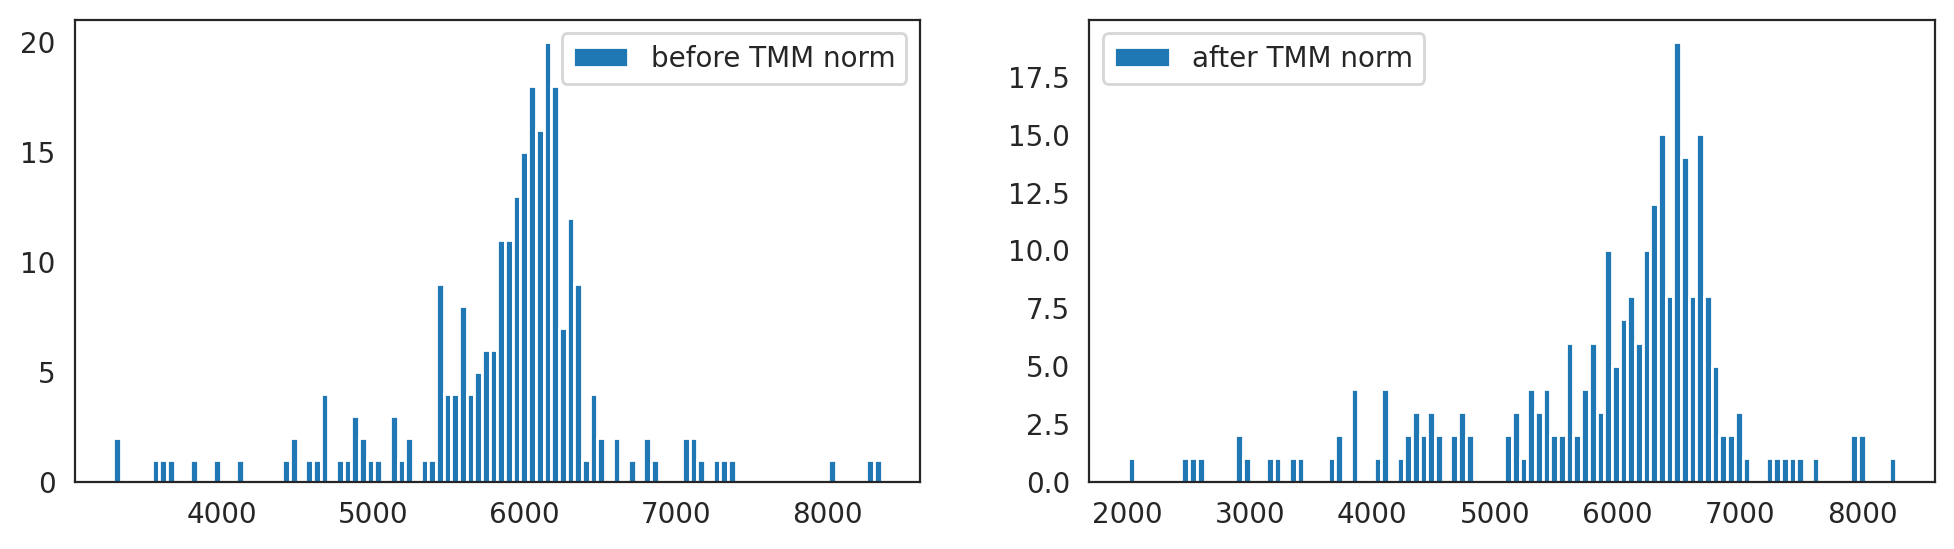

In [36]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(pseudobulk.X.sum(axis=1), bins=100, log=False, label="before TMM norm")
axes[1].hist(ingestion.tmmNormalization((pseudobulk.X + 0.0001).T).T.sum(axis=1), bins=100, log=False, label="after TMM norm")
axes[0].legend()
axes[1].legend()
plt.show()

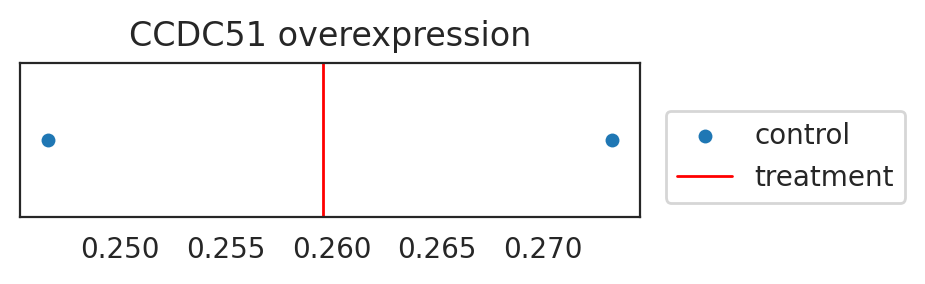

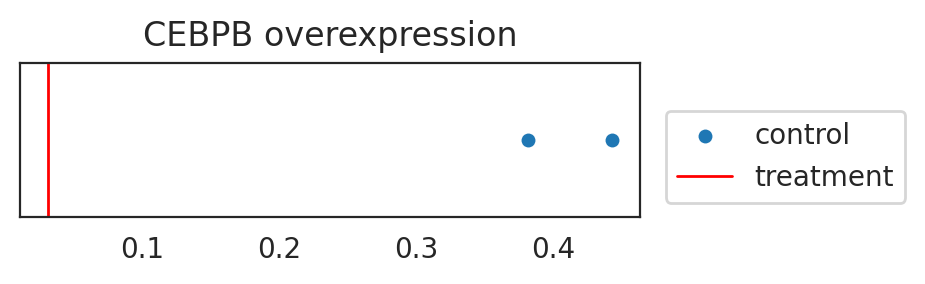

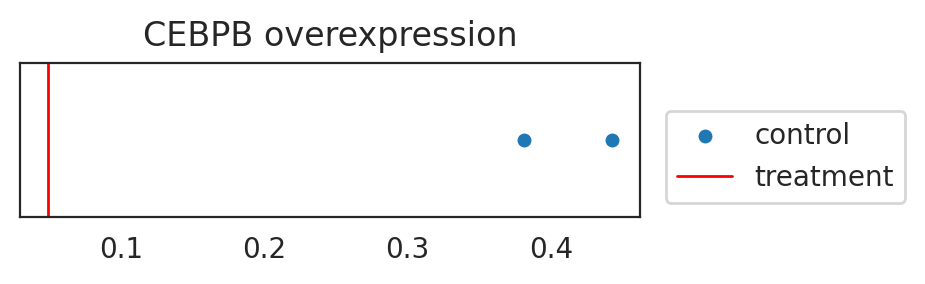

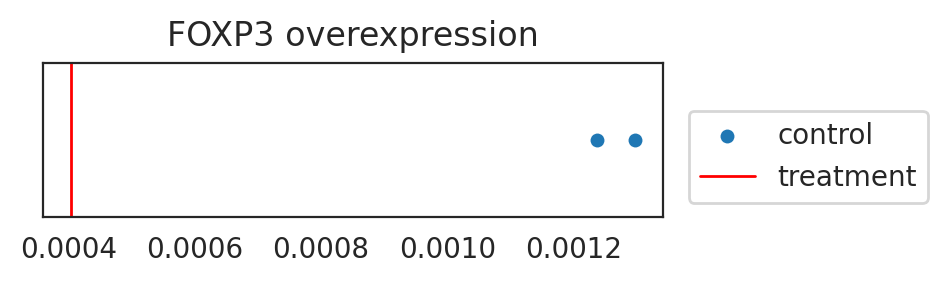

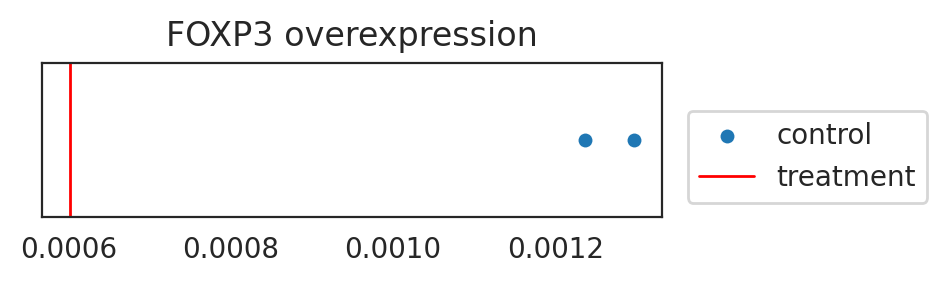

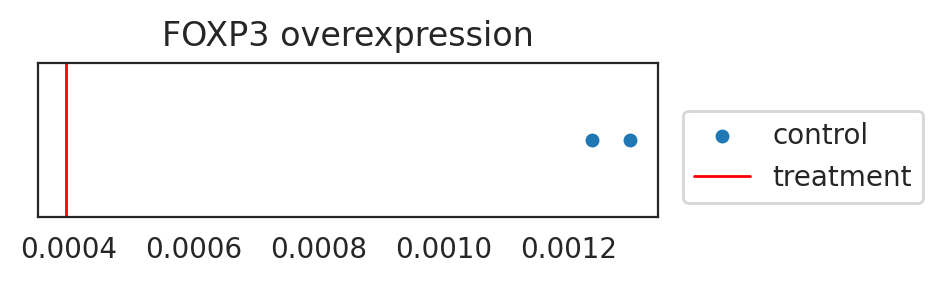

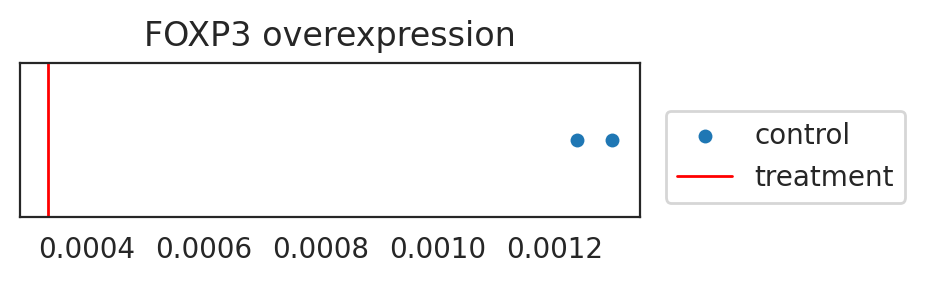

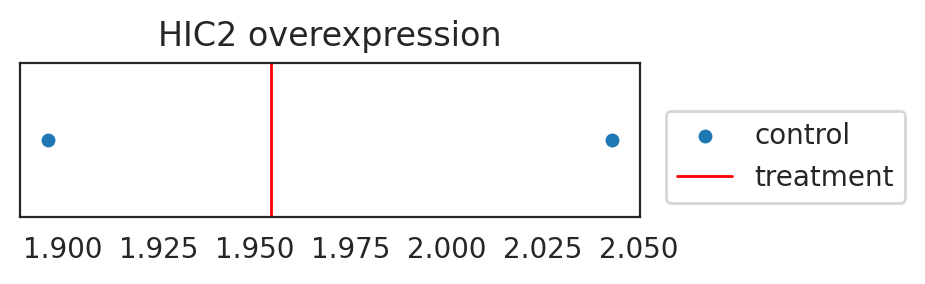

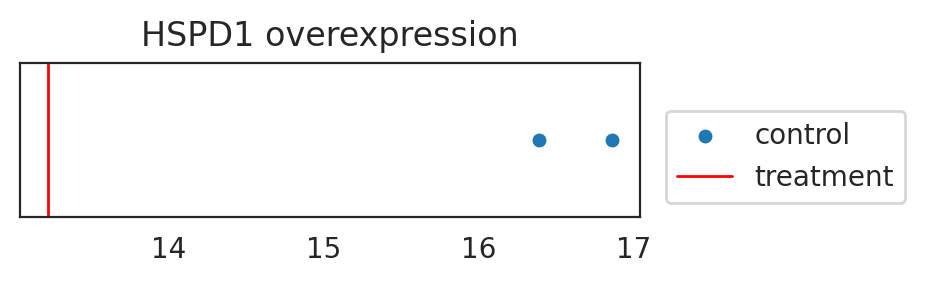

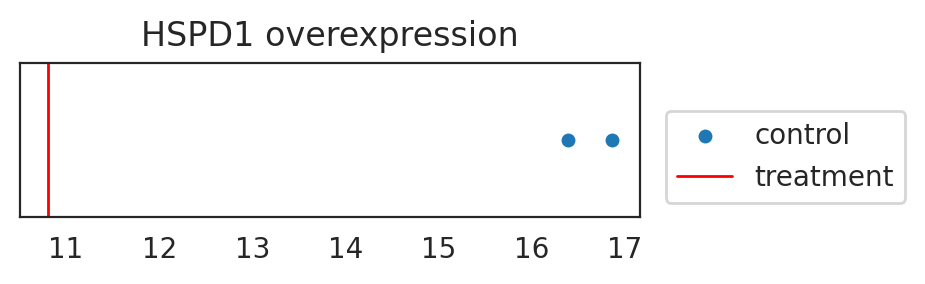

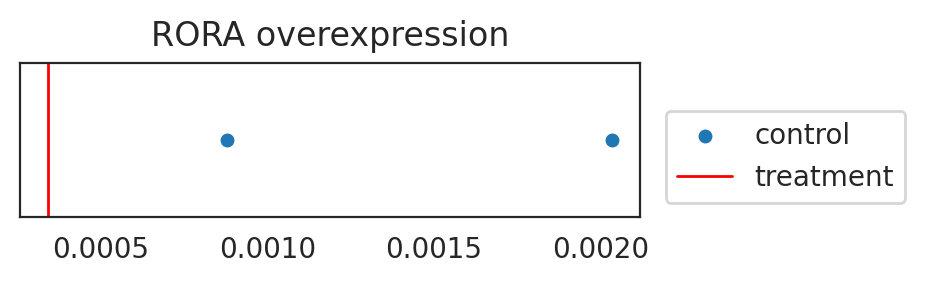

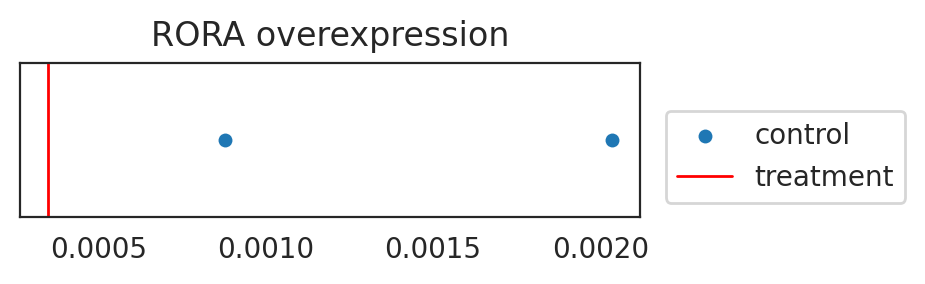

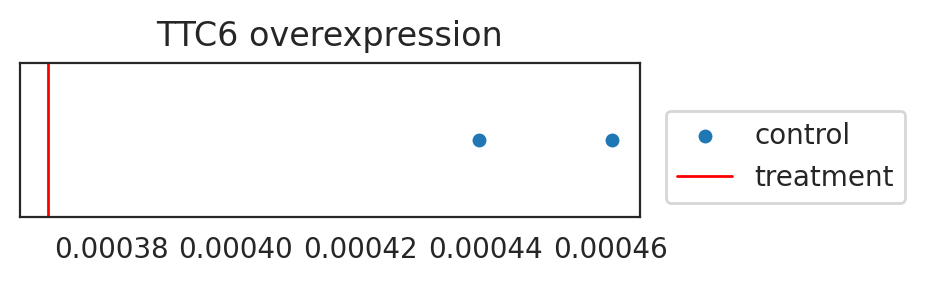

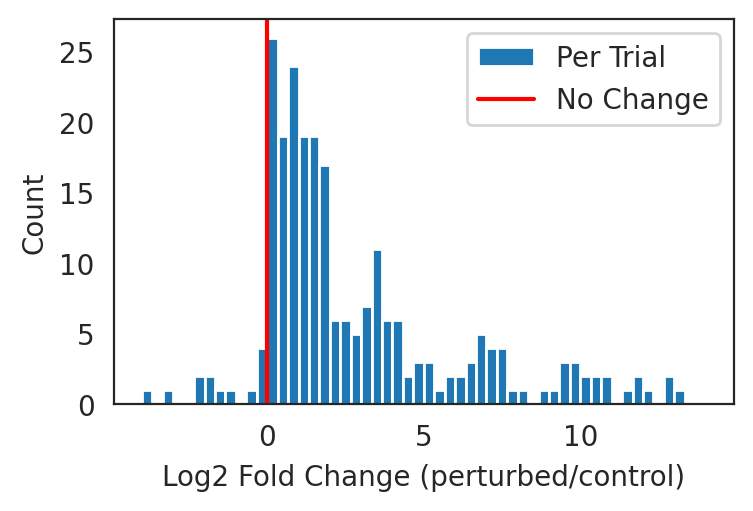

Counter({'NA': 18, 'Yes': 223, 'No': 13})

In [37]:
# If verbose is set to True, display disconcordant trials and their controls
status, logFC = ingestion.checkConsistency(pseudobulk, 
                                           perturbationType="overexpression", 
                                           group=None,
                                           verbose=True) 
pseudobulk.obs["consistentW/Perturbation"] = status
pseudobulk.obs["logFC"] = logFC
Counter(status)

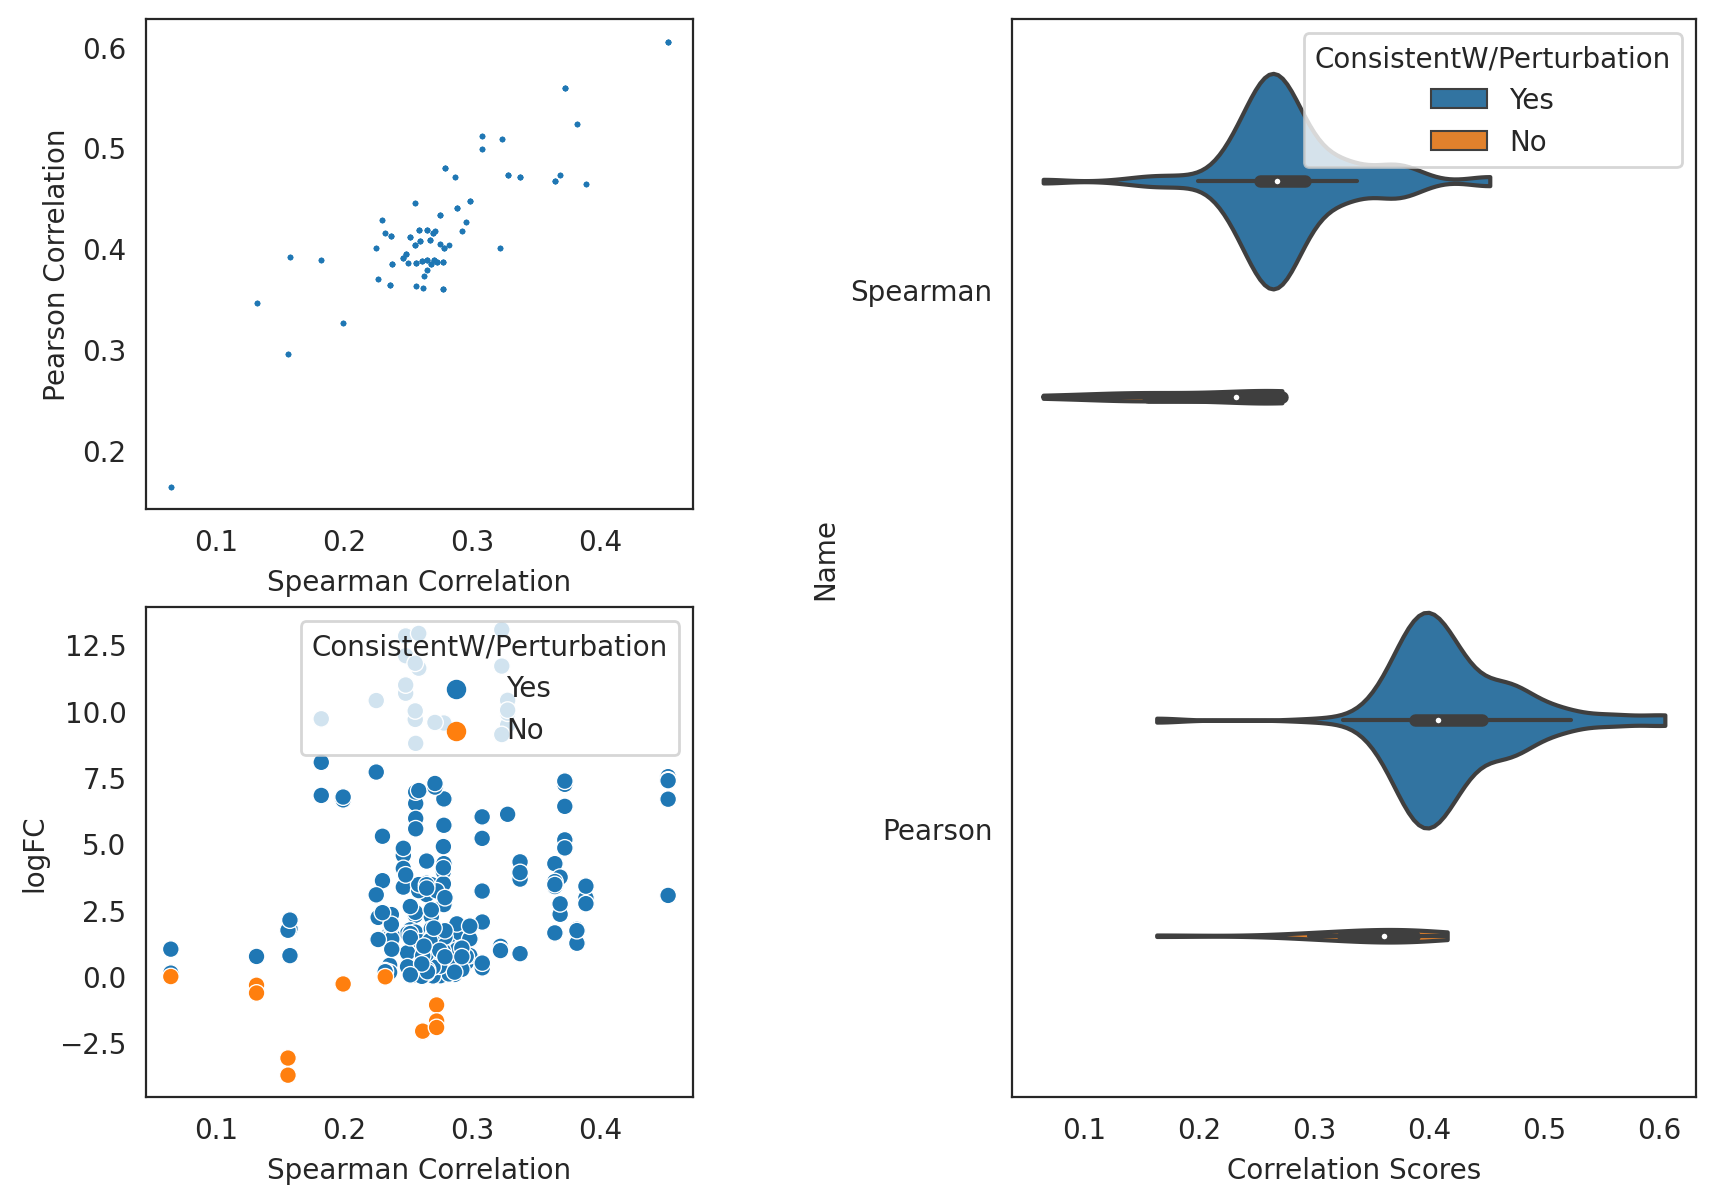

In [38]:
correlations = ingestion.computeCorrelation(pseudobulk, verbose=True)
pseudobulk.obs["spearmanCorr"] = correlations[0]
pseudobulk.obs[ "pearsonCorr"] = correlations[1]

In [39]:
(diffExprGene,
 mutualInfo,
 logFCMean,
 logFCNorm2,
 logFCMedian) = ingestion.quantifyEffect(adata=pseudobulk, 
                                         fname="setup/replogle1.csv", 
                                         diffExprFC=False)

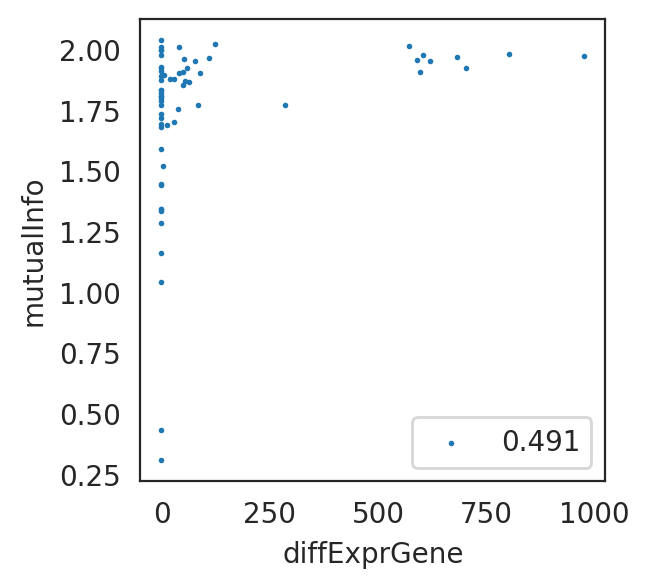

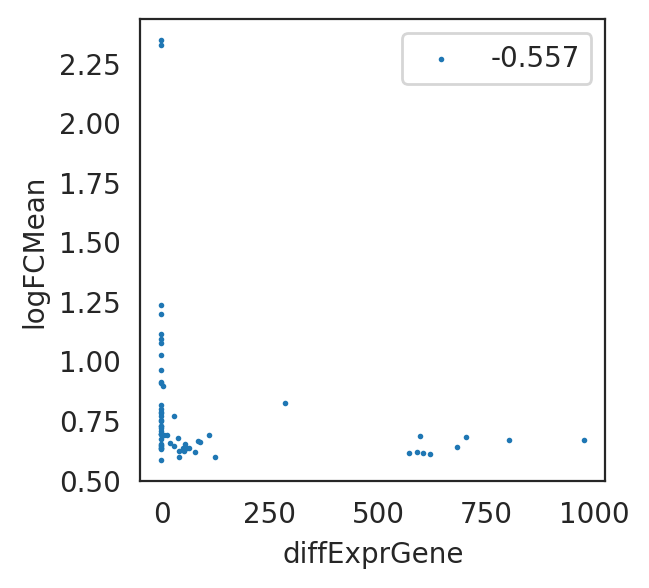

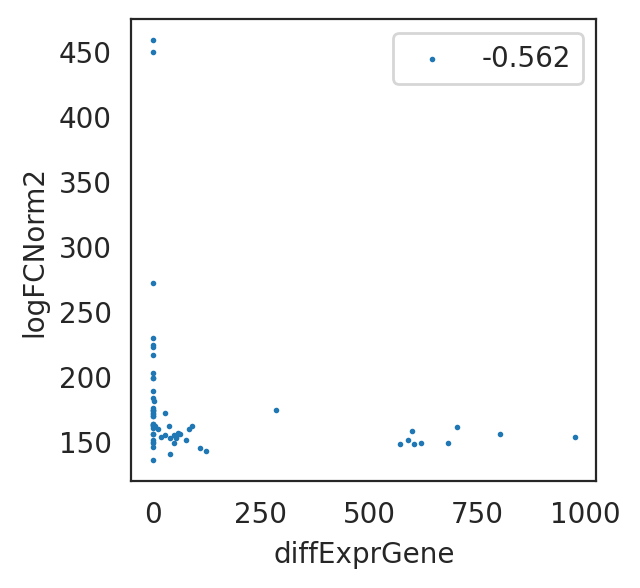

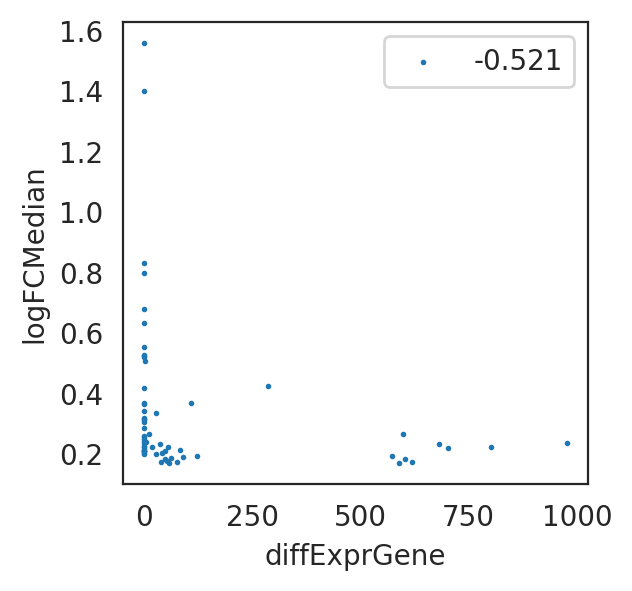

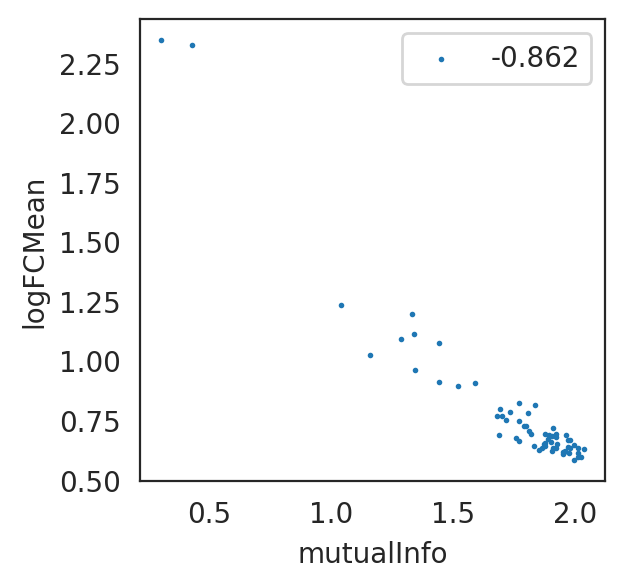

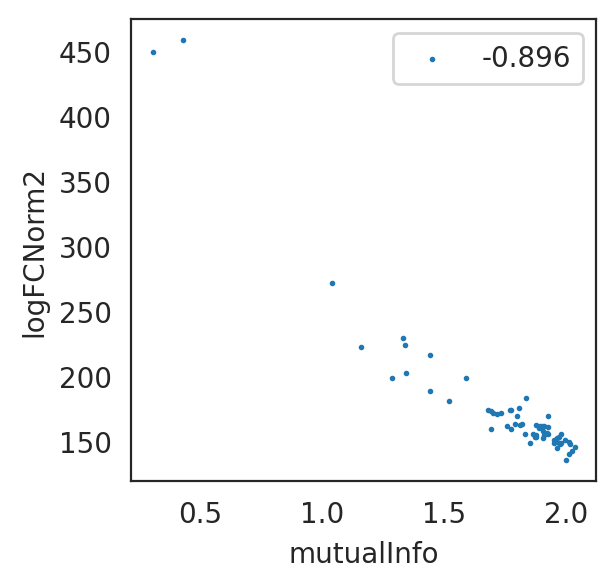

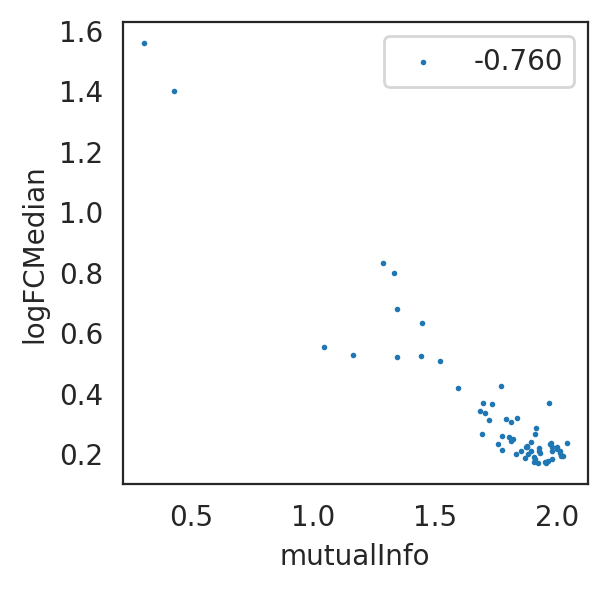

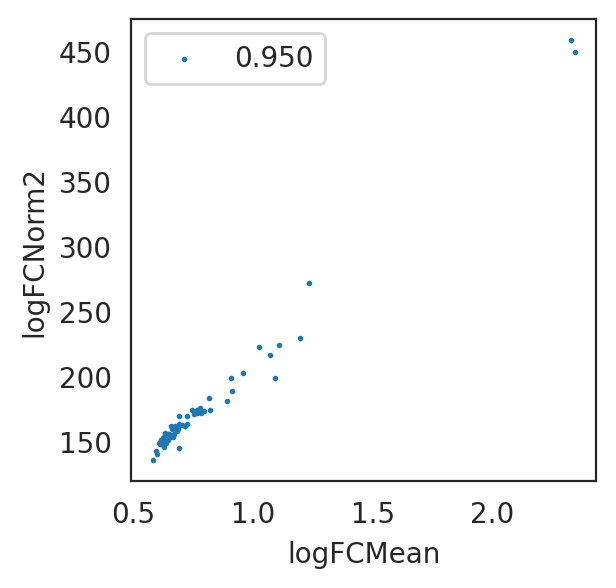

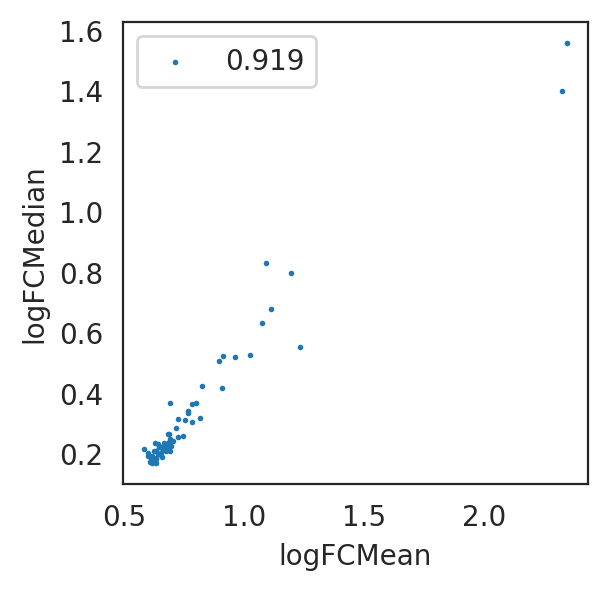

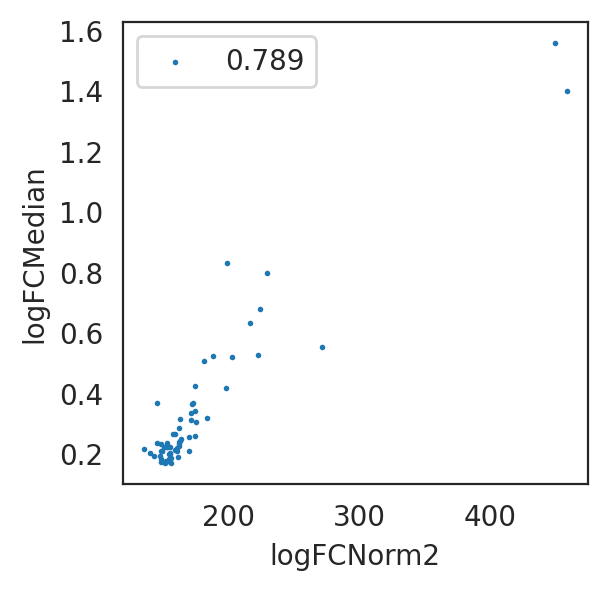

In [40]:
def checkMetricCorrelation(metric1: np.ndarray, metric2: np.ndarray, n1: str, n2: str): 
    plt.figure(figsize=(3,3))
    plt.scatter(metric1, 
                metric2, 
                s=1, 
                label=f"{spearmanr(metric1, metric2)[0]:.3f}")
    plt.xlabel(n1)
    plt.ylabel(n2)
    plt.legend()
    plt.show()
    
listOfMetrics = ["diffExprGene", "mutualInfo", "logFCMean", "logFCNorm2", "logFCMedian"]
for (p1, p2) in it.combinations(listOfMetrics, r=2):
    checkMetricCorrelation(eval(p1), eval(p2), p1, p2)

In [41]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv("setup/tfList.csv", index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv("setup/epiList.csv", index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

perturbagenList = np.array(sorted(set(pseudobulk.obs.perturbation) - set(controls)))
perturbagenStatus = np.array(["Yes" if p in TFDict or p in EpiDict else "No" for p in perturbagenList])
colorDict = {'No': '#1f77b4', 'Yes': '#ff7f0e'}
perturbagenColor = [colorDict[p] for p in perturbagenStatus]

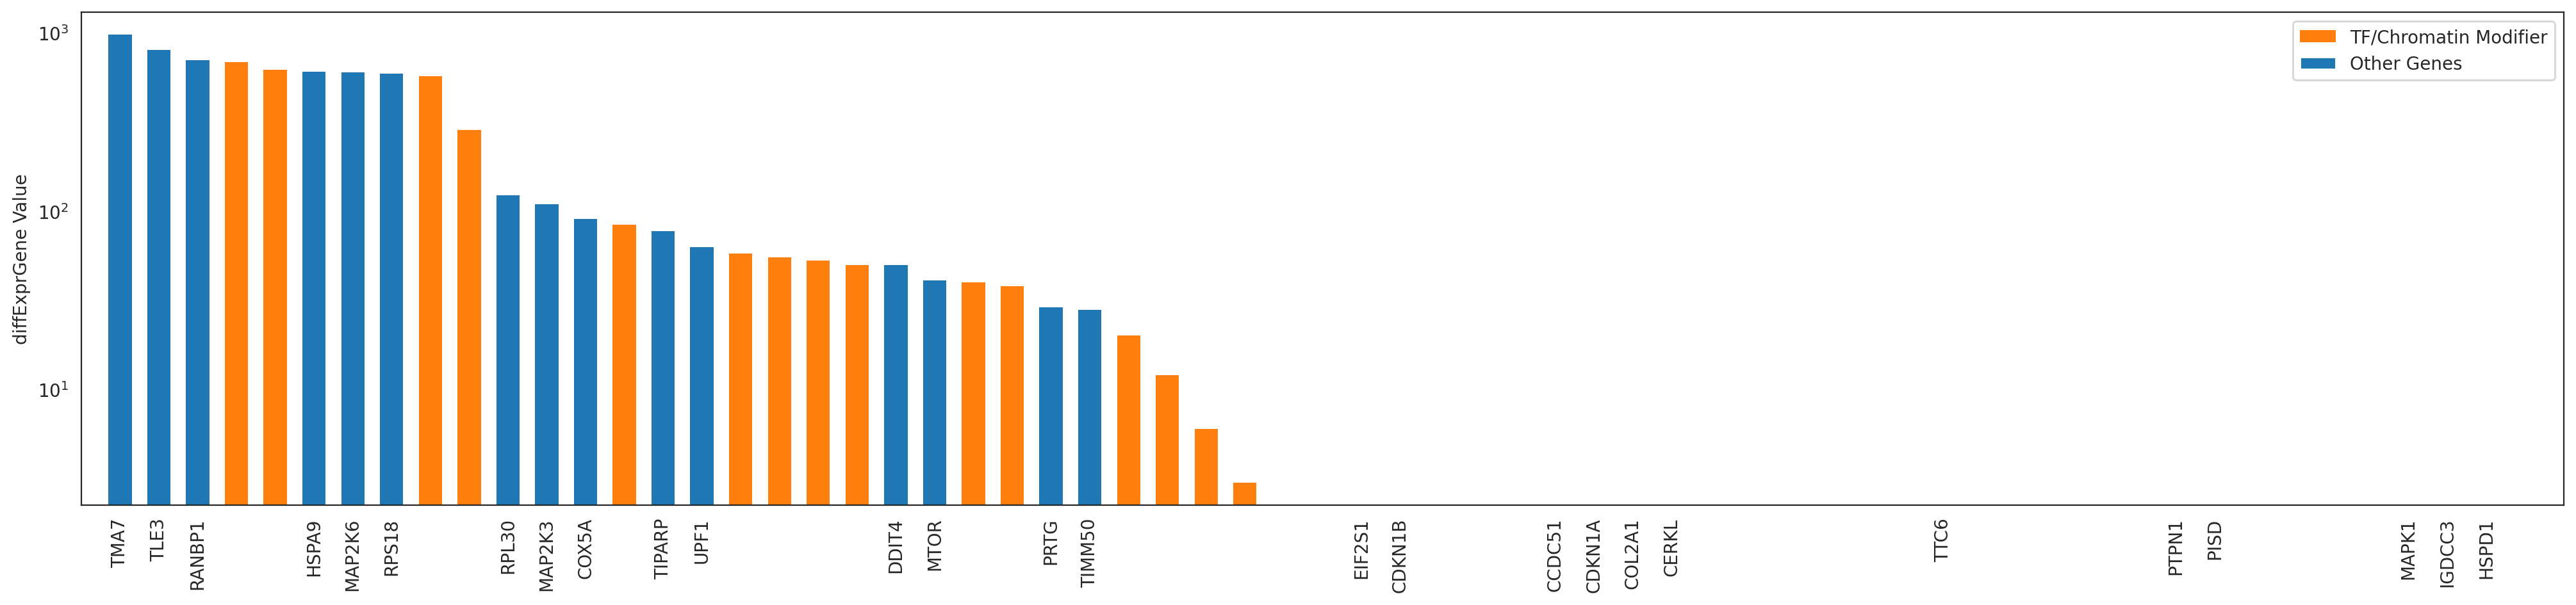

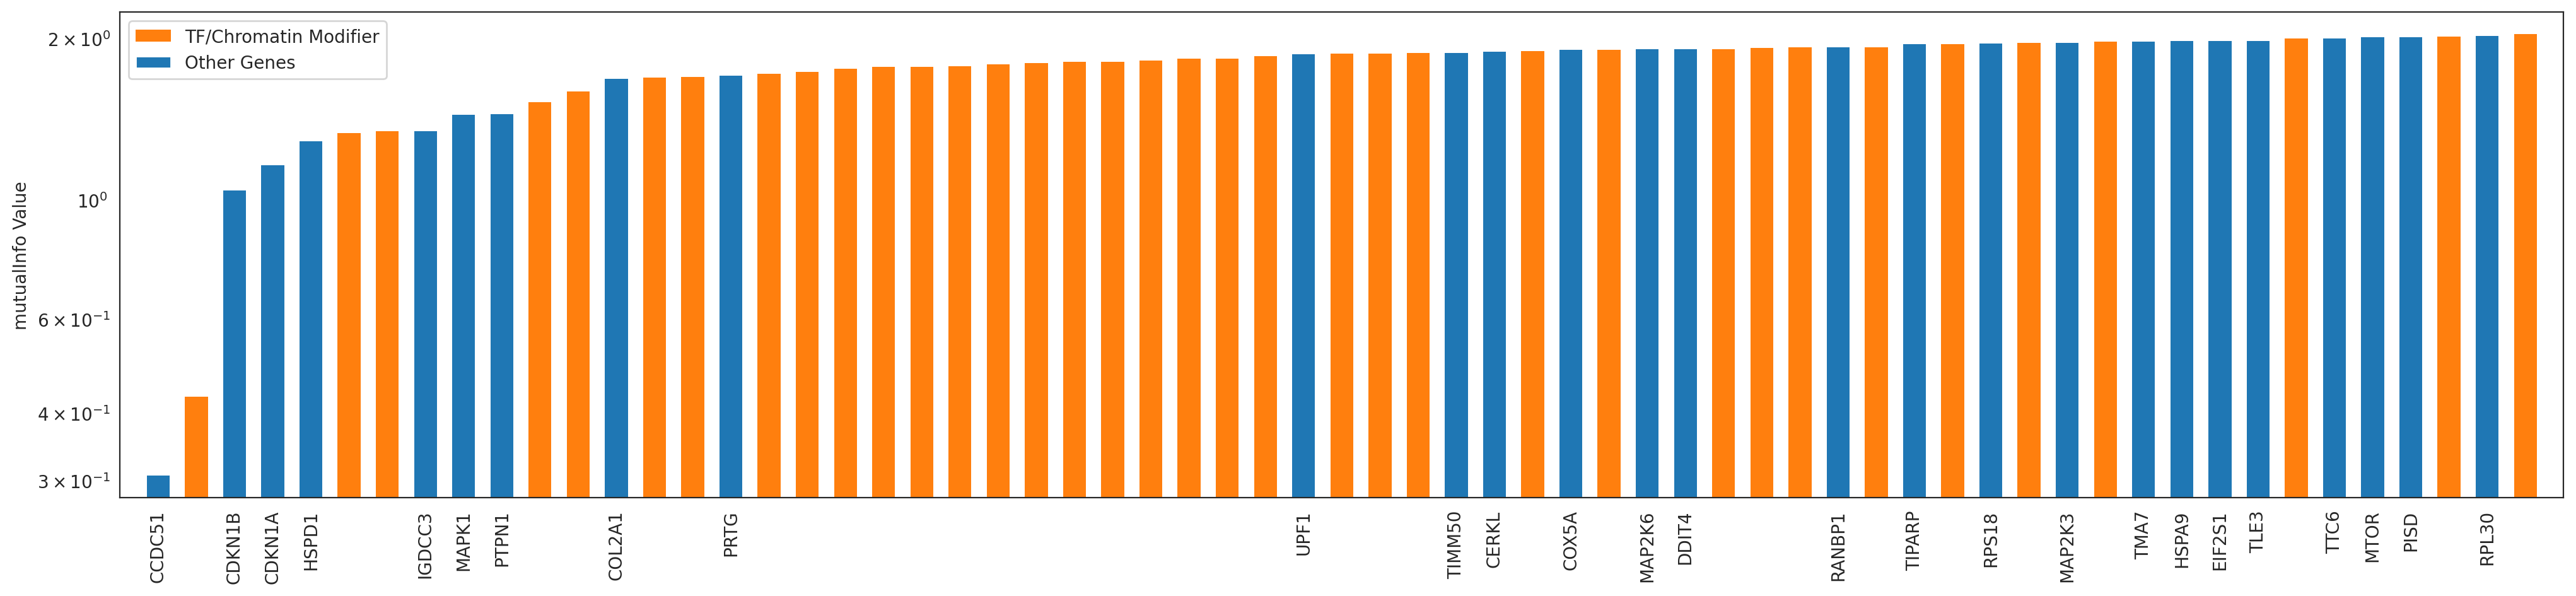

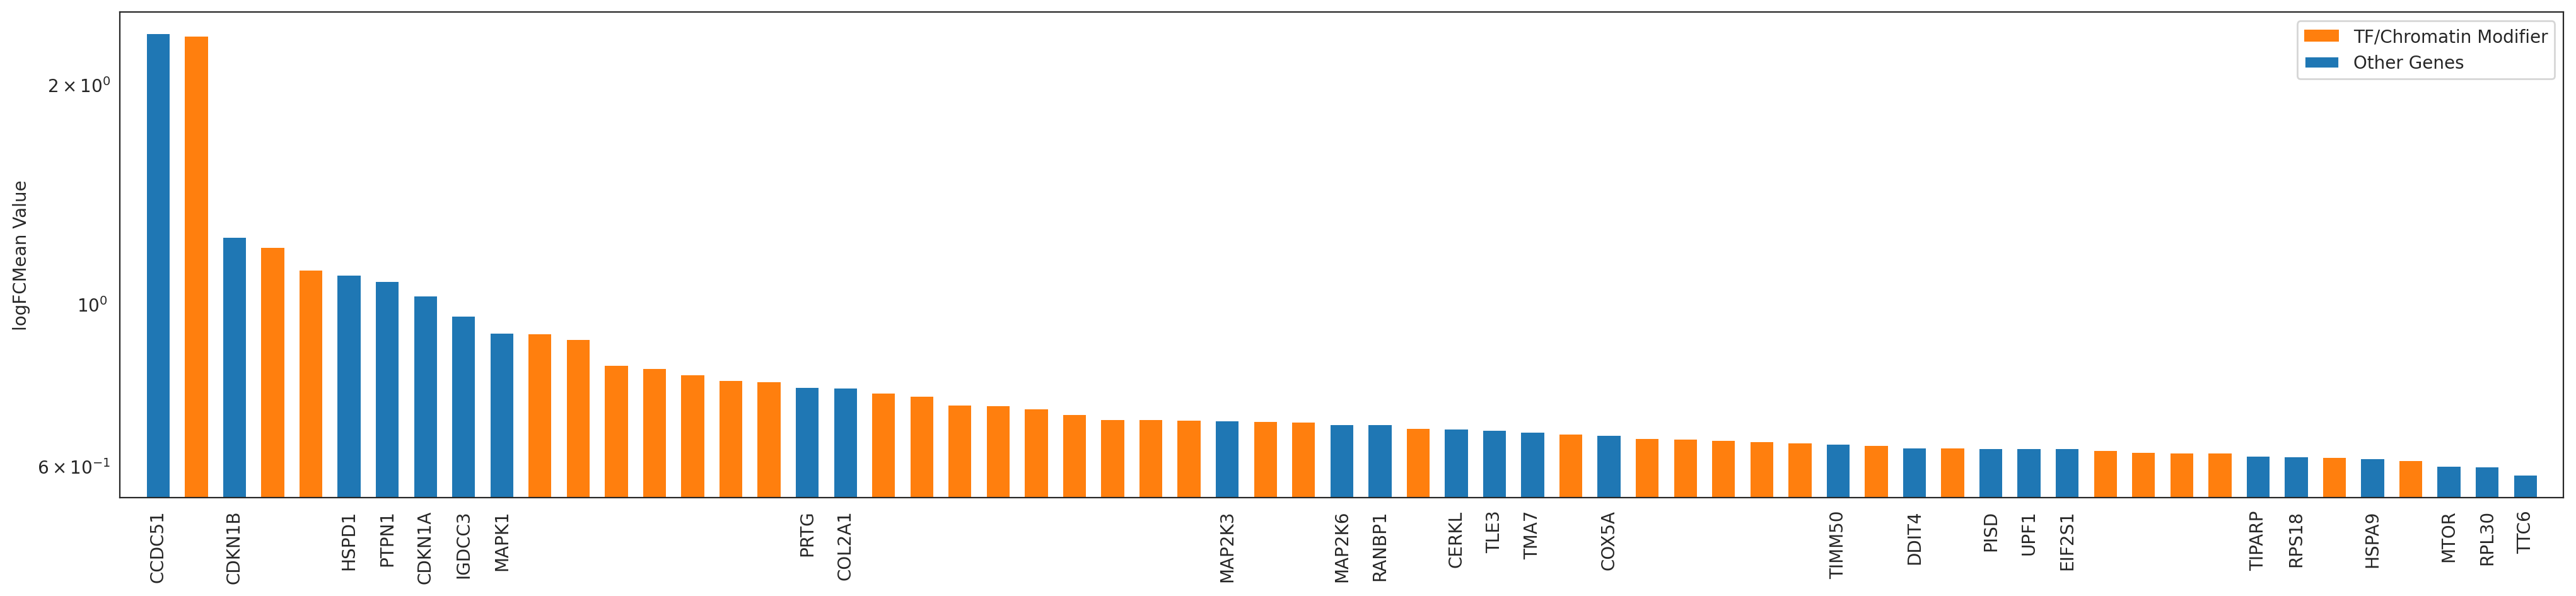

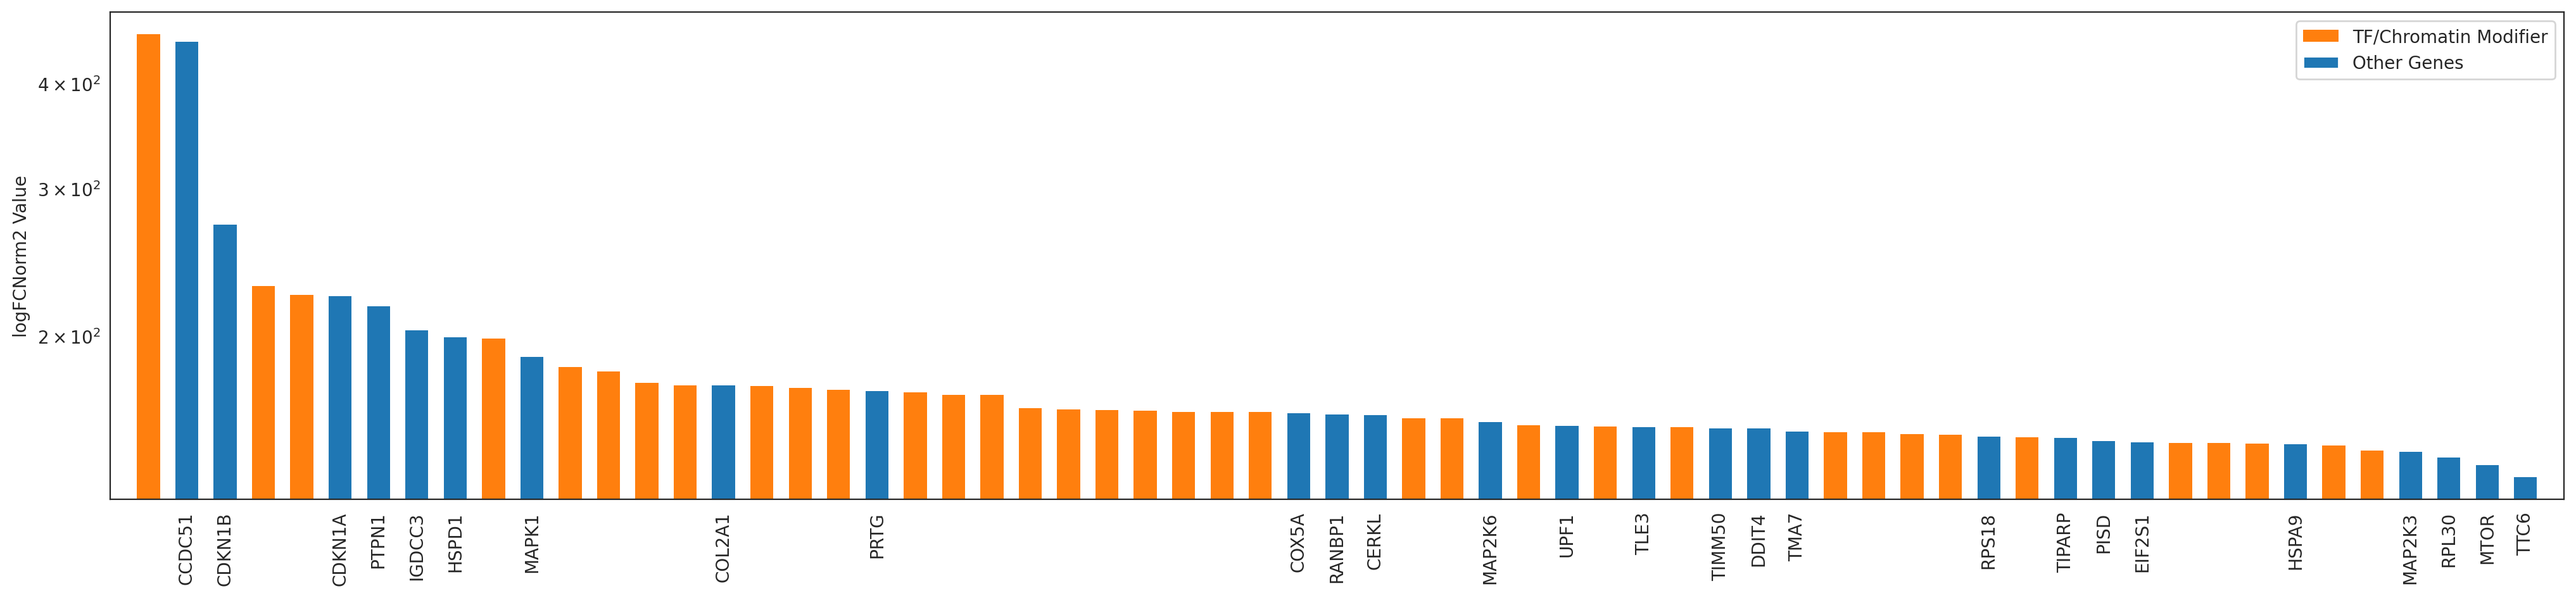

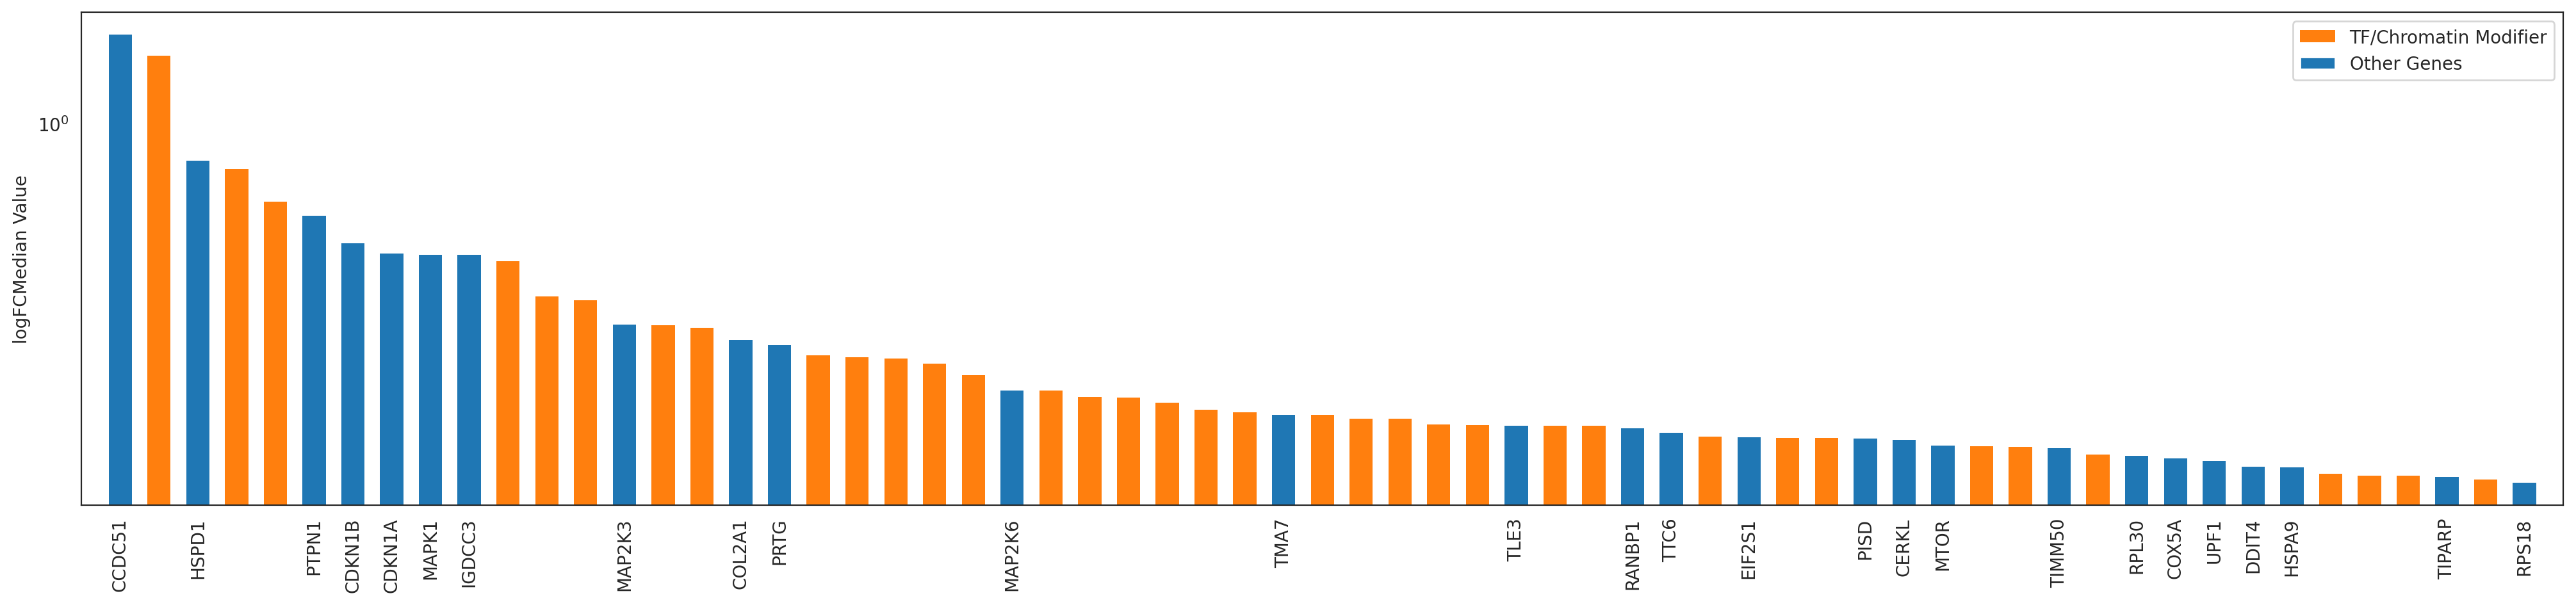

In [42]:
""" Everything is artificially shifted right by one 
since a non-visible bar (with height=0) is
inserted at the beginning. This is done to coerce the
legend color for TF/Chromatin Modifier to be 'orange' """

for idx, p1 in enumerate(listOfMetrics):
    plt.figure(figsize=(25,5))
    index = np.argsort(eval(p1))[::-1]
    if idx == 1:
        index = index[::-1]

    plt.bar(np.arange(diffExprGene.shape[0]+1), [0] + list(eval(p1)[index]), width=0.6, 
            linewidth=0, color=['#ff7f0e'] + list(np.array(perturbagenColor)[index]), log=True, label="TF/Chromatin Modifier")
    plt.bar(range(0), 0, label="Other Genes")
    
    otherGene = np.array([(i+1,p) for i,p in enumerate(perturbagenList[index]) if perturbagenStatus[index][i] == 'No'])
    otherGene = np.insert(otherGene, 0, [0, ""], axis=0)
    
    plt.legend()
    plt.ylabel(f"{p1} Value")
    plt.xticks(otherGene[:,0].astype(int), otherGene[:,1], rotation=90, fontsize=10)
    plt.xlim([0, len(perturbagenList)+1])
    plt.show()

In [43]:
expression_quantified.obs['DEG'] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['MI' ] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['logFCMean'  ] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['logFCNorm2' ] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['logFCMedian'] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)

for idx, p in enumerate(perturbagenList):
    rows = np.where(expression_quantified.obs.perturbation == p)[0]
    expression_quantified.obs['DEG'][rows] = diffExprGene[idx]
    expression_quantified.obs['MI' ][rows] = mutualInfo[idx]
    expression_quantified.obs['logFCMean'  ][rows] = logFCMean[idx]
    expression_quantified.obs['logFCNorm2' ][rows] = logFCNorm2[idx]
    expression_quantified.obs['logFCMedian'][rows] = logFCMedian[idx]
    
validRow = (expression_quantified.obs['spearmanCorr'] != -999) & (expression_quantified.obs['logFC'] != -999)
validMat = expression_quantified.obs[validRow]

plt.figure(figsize=(7, 5))
g =sns.scatterplot(data=validMat, 
                x='spearmanCorr', 
                y='logFC', 
                style='consistentW/Perturbation', 
                hue='logFCNorm2', 
                palette=sns.color_palette("coolwarm", as_cmap=True), 
                markers=['o', '^', '*'], 
                legend='brief')
plt.axhline(0, 0, 1, linestyle='-.', color='brown')
g.legend(loc='lower right', bbox_to_anchor=(1.45, 0), ncol=1)
plt.xlim([-0.2, 1])

KeyError: 'spearmanCorr'

### Basic EDA

In [ ]:
sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)
cc_genes = pd.read_csv("../accessory_data/regev_lab_cell_cycle_genes.txt", header = None)[0]
sc.tl.score_genes_cell_cycle(expression_quantified, s_genes=cc_genes[:43], g2m_genes=cc_genes[43:])

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(expression_quantified, color = [
    "PTPRC",
    "leiden", 
    "is_control_int",
    "perturbation",
    'S_score',
    'G2M_score', 
    'phase', 
    'total_counts', 
    'log1p_total_counts',
    'pct_counts_in_top_50_genes', 
    'has_guide_annotations',
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [ ]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_genes.remove(np.nan)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
print("These genes were perturbed:")
print(perturbed_genes)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

In [ ]:
# final form, ready to save
expression_quantified.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
expression_quantified = ingestion.describe_perturbation_effect(expression_quantified, "overexpression")

In [ ]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
expression_quantified.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")